### Load Data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/raw/yc_startups.csv")
print(df.head())

       name                         location  \
0      mrge  London, England, United Kingdom   
1    Partcl           San Francisco, CA, USA   
2  LineWise                              NaN   
3     Linkd           San Francisco, CA, USA   
4   StarJar                              NaN   

                                         description  
0                    AI-powered code review platform  
1                  GPU accelerated chip design tools  
2  Help manufacturers capture, scale, and apply t...  
3     Find warm connections you didn’t know you had.  
4  Starjar automates inbound document processing ...  


### Inspect Data

In [3]:
print(df.info())
print(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         1000 non-null   object
 1   location     784 non-null    object
 2   description  997 non-null    object
dtypes: object(3)
memory usage: 23.6+ KB
None
         name                location description
count    1000                     784         997
unique    998                      75         996
top     Ultra  San Francisco, CA, USA     Stealth
freq        2                     499           2


In [4]:
df.drop_duplicates(inplace=True)
print(df.describe(include='all'))

         name                location description
count    1000                     784         997
unique    998                      75         996
top     Ultra  San Francisco, CA, USA     Stealth
freq        2                     499           2


### Minimal Text Cleaning

In [5]:
import re

def clean_text(text):
    # Ensure text is a string (in case of missing values)
    if not isinstance(text, str):
        return ""
    # Remove non-alphanumeric characters (except spaces) and lowercase the text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower()

# Apply cleaning function on the description column (create a new column for cleaned text)
df['cleaned_description'] = df['description'].apply(clean_text)
print(df[['description', 'cleaned_description']].head())

                                         description  \
0                    AI-powered code review platform   
1                  GPU accelerated chip design tools   
2  Help manufacturers capture, scale, and apply t...   
3     Find warm connections you didn’t know you had.   
4  Starjar automates inbound document processing ...   

                                 cleaned_description  
0                     aipowered code review platform  
1                  gpu accelerated chip design tools  
2  help manufacturers capture scale and apply tri...  
3       find warm connections you didnt know you had  
4  starjar automates inbound document processing ...  


### Basic EDA

In [6]:
sf = len(df[df['location'] == "San Francisco, CA, USA"])
nyc = len(df[df['location'] == "New York, NY, USA"])
valid = len(df) - len(df[df['location'].isna()])
print(f"San Francisco: {sf} ({sf/valid*100:.2f}%)")
print(f"New York: {nyc} ({nyc/valid*100:.2f}%)")
print(f"Other: {valid - sf - nyc} ({(valid - sf - nyc)/valid*100:.2f}%)")

San Francisco: 499 (63.65%)
New York: 93 (11.86%)
Other: 192 (24.49%)


In [7]:
from collections import Counter

# Combine all cleaned descriptions into one large text
all_text = " ".join(df['cleaned_description'])
words = all_text.split()
word_counts = Counter(words)

# Display the top 20 most common words
print(word_counts.most_common(20))


[('for', 512), ('ai', 398), ('and', 160), ('the', 152), ('to', 98), ('with', 83), ('agents', 73), ('platform', 63), ('your', 63), ('data', 56), ('that', 51), ('in', 51), ('software', 50), ('aipowered', 48), ('a', 36), ('of', 31), ('building', 29), ('an', 29), ('copilot', 29), ('source', 27)]


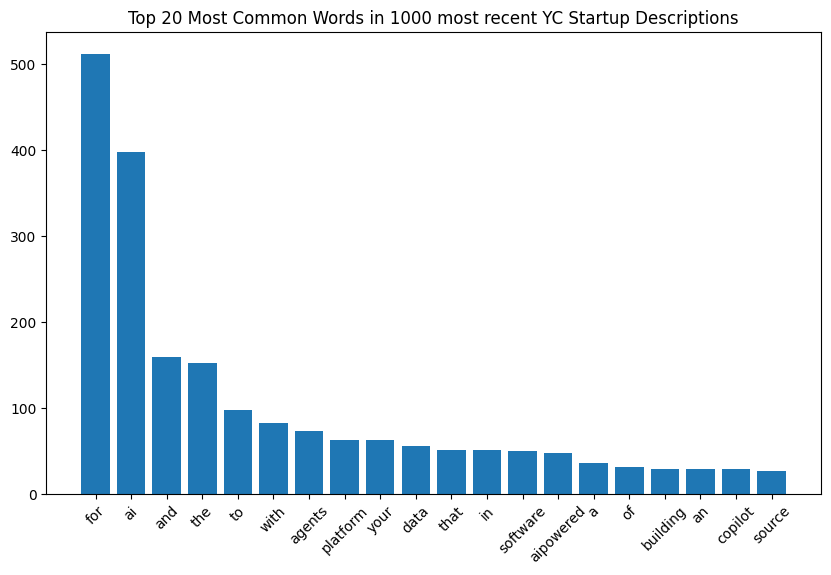

In [8]:
import matplotlib.pyplot as plt

# Get the top 20 words and their counts
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words in 1000 most recent YC Startup Descriptions")
plt.show()

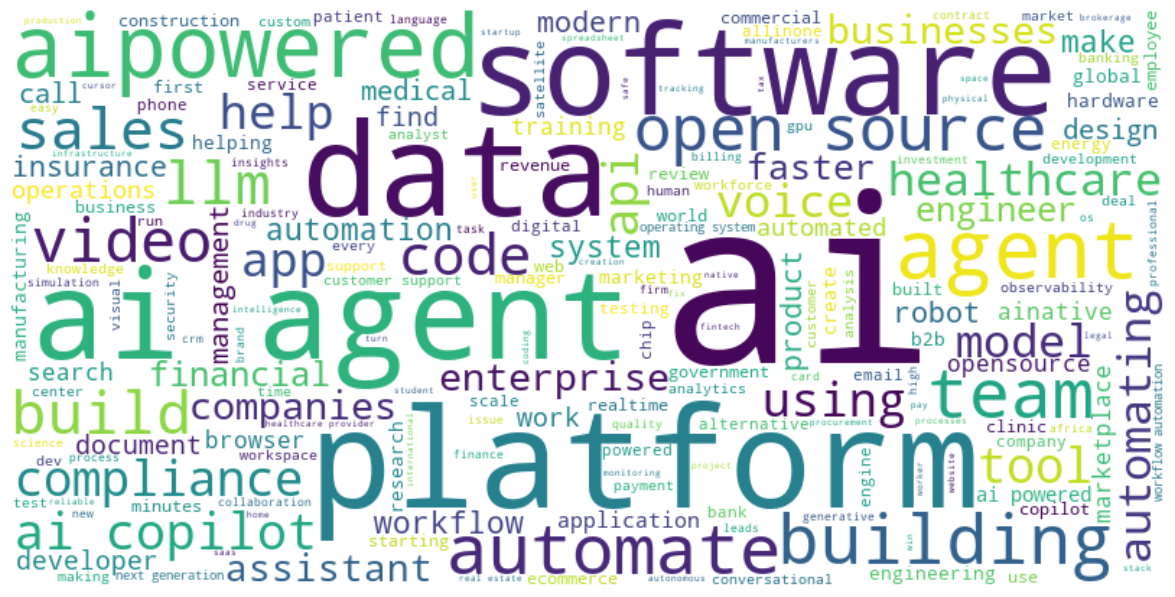

In [9]:
from wordcloud import WordCloud

# Create and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


### Topic Modeling with LDA

Extract latent topics from the descriptions using Latent Dirichlet Allocation (LDA). This helps in detecting clusters of related words that represent trends.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_description'])

In [11]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [12]:
# Number of words to display per topic
n_top_words = 10

for index, topic in enumerate(lda_model.components_):
    print(f"\nTOPIC #{index + 1}")
    # Get the indices of the top words
    top_indices = topic.argsort()[-n_top_words:]
    # Map indices to actual words
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices]
    print(top_words)



TOPIC #1
['global', 'create', 'build', 'teams', 'opensource', 'assistant', 'data', 'companies', 'platform', 'ai']

TOPIC #2
['providers', 'platform', 'calls', 'healthcare', 'clinics', 'automation', 'automate', 'ainative', 'insurance', 'ai']

TOPIC #3
['api', 'hardware', 'automating', 'search', 'agent', 'software', 'building', 'aipowered', 'data', 'ai']

TOPIC #4
['language', 'generation', 'browser', 'video', 'sales', 'code', 'platform', 'aipowered', 'agents', 'ai']

TOPIC #5
['financial', 'automate', 'voice', 'copilot', 'compliance', 'software', 'open', 'source', 'agents', 'ai']
